## **Insurance Cross Sell Prediction**

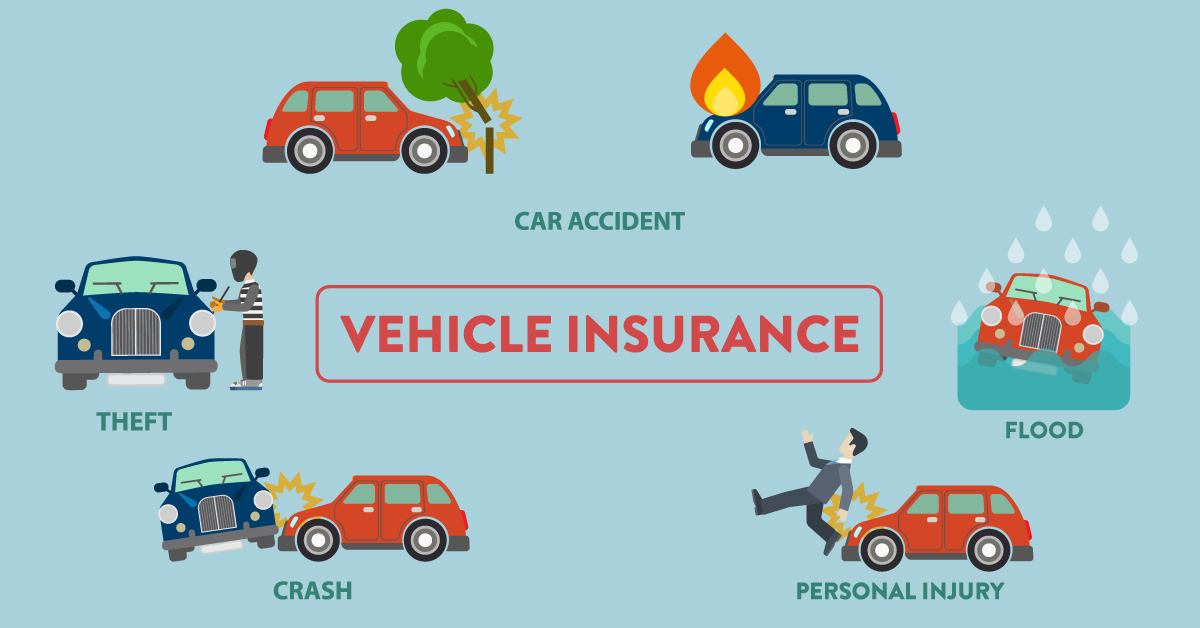


# **1. 데이터 선정 이유 및 문제 정의:**

> 데이터셋 설명:
*   보험 회사의 현재 의료보험 가입자들이 새로 나올 상품인 자동차보험에 관심이 있는지를 기록한 데이터로, 현재 가입자 샘플들의 demographics, vehicles information, policy information을 담고있다.

> 데이터셋 선정이유:
*   기업들은 데이터를 많이 모으고, 그 축적된 고객 데이터를 기반으로 더 좋은 서비스와 상품을 제공하거나 더 효율적인 세일즈를 하고 싶어한다.
*   새로운 상품이 출시가 되었을 때에, 이미 회사가 가지고 있는 기존 고객 데이터를 토대로 마케팅 전략을 세운다면 더 좋은 효율성을 기대할 수 있을 것이다.
*   이미 회사에 대한 신뢰도가 있고 만족하고 있는 고객들을 target market으로 하여, 새로운 상품에 더 관심을 가질 segment만 집중하여 cross selling을 시도한다면, 시간과 효율을 더 극대화하고 더 높은 이익을 창출할 수 있지 않을까?

> 모델링 목표:
*   기존 의료보험 가입자들이 새로운 자동차보험 상품에 관심을 가질것인지를 예측하는 모델을 만들자

> 타겟으로 사용할 특성:
*   Response를 타겟 특성으로 선택
*   관심을 가질 확률이 더 높은 사람에게 먼저 아웃바운드 세일즈 콜링을 하기 위해서

> 해당 특성을 타겟으로 지정한 이유:
> 해당 베이스라인 모델과 평가지표를 선택한 이유를 설명

> 어떤 유형으로 접근:
*   Response를 yes/no로 지정하여 분류 문제로 접근하여 모델링

> Dataset Links
https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction


## **Data Description**

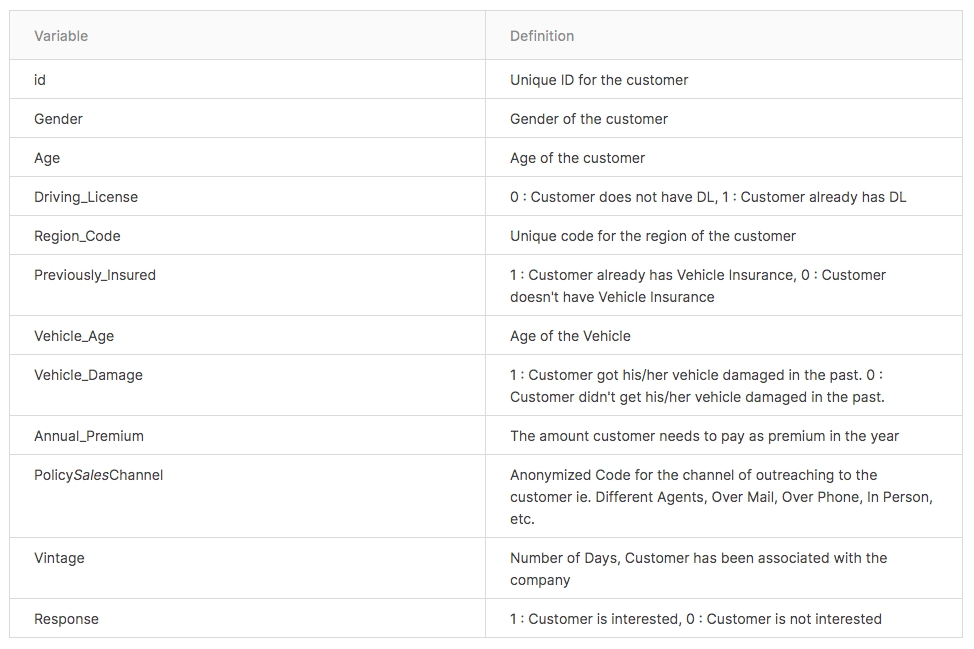



---


# **2. 데이터 준비**


##Part 1: Import Dataset + Libraries

In [1]:
# 필요한 라이브러리들 먼저 호출하고 시작

%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install catboost

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="whitegrid")
pd.options.display.float_format = '{:,.4f}'.format

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, mean_absolute_error, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 


In [2]:
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [4]:
!pip install kaggle --quiet kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chloe18","key":"f8ed6df18b3aefeea062fca5b2ce9876"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d anmolkumar/health-insurance-cross-sell-prediction

health-insurance-cross-sell-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip health-insurance-cross-sell-prediction.zip -d .

Archive:  health-insurance-cross-sell-prediction.zip
replace ./sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./sample_submission.csv  
  inflating: ./test.csv              
  inflating: ./train.csv             


In [9]:
# 데이터셋 저장

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sample_submit = pd.read_csv('/content/sample_submission.csv')

In [10]:
print(train.shape)
train.head(3)

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,"40,454.0000",26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,"33,536.0000",26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,"38,294.0000",26.0000,27,1


In [11]:
print(test.shape)
test.head(3)

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0000,1,< 1 Year,No,"35,786.0000",152.0000,53
1,381111,Male,40,1,28.0000,0,1-2 Year,Yes,"33,762.0000",7.0000,111
2,381112,Male,47,1,28.0000,0,1-2 Year,Yes,"40,050.0000",124.0000,199


In [12]:
print(sample_submit.shape)
sample_submit.head(3)

(127037, 2)


,id,Response
0,381110,0
1,381111,0
2,381112,0




---
## Part 2: Data Preprocessing + EDA



In [13]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,"40,454.0000",26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,"33,536.0000",26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,"38,294.0000",26.0000,27,1
3,4,Male,21,1,11.0000,1,< 1 Year,No,"28,619.0000",152.0000,203,0
4,5,Female,29,1,41.0000,1,< 1 Year,No,"27,496.0000",152.0000,39,0


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [15]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,"381,109.0000",NaN,NaN,NaN,"190,555.0000","110,016.8362",1.0000,"95,278.0000","190,555.0000","285,832.0000","381,109.0000"
Gender,381109,2,Male,206089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,"381,109.0000",NaN,NaN,NaN,38.8226,15.5116,20.0000,25.0000,36.0000,49.0000,85.0000
Driving_License,"381,109.0000",NaN,NaN,NaN,0.9979,0.0461,0.0000,1.0000,1.0000,1.0000,1.0000
Region_Code,"381,109.0000",NaN,NaN,NaN,26.3888,13.2299,0.0000,15.0000,28.0000,35.0000,52.0000
Previously_Insured,"381,109.0000",NaN,NaN,NaN,0.4582,0.4983,0.0000,0.0000,0.0000,1.0000,1.0000
Vehicle_Age,381109,3,1-2 Year,200316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_Damage,381109,2,Yes,192413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Premium,"381,109.0000",NaN,NaN,NaN,"30,564.3896","17,213.1551","2,630.0000","24,405.0000","31,669.0000","39,400.0000","540,165.0000"
Policy_Sales_Channel,"381,109.0000",NaN,NaN,NaN,112.0343,54.2040,1.0000,29.0000,133.0000,152.0000,163.0000


In [16]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]



---


> 중복값 / 결측치가 있는지 먼저 확인해보겠습니다











In [17]:
train.duplicated().sum()

0

In [18]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64



---


> 이상치에 대해서 확인하고 처리해주겠습니다

Text(0.5, 1.0, 'Annual_Premium')

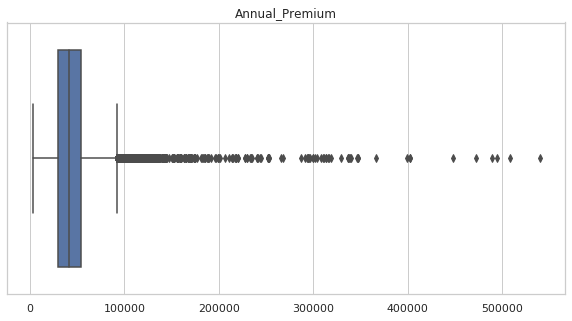

In [19]:
# boxplot 그래프를 그려서 이상치를 확인

plt.figure(figsize=(10,5))
sns.boxplot(train['Annual_Premium'].unique())
plt.title('Annual_Premium')


In [20]:
def remove_outlier(df, col): 

  q1, q3 = np.quantile(df[col], 0.25), np.quantile(df[col], 0.75)             
  iqr = q3 - q1       
  lower, upper = q1 - (iqr * 1.5), q3 + (iqr * 1.5)   
  
  removed = df[df[col].between(lower, upper)]

  return removed

In [21]:
train = remove_outlier(train, 'Annual_Premium')

In [22]:
print(train.shape)
train.head(3)

(370789, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0000,0,> 2 Years,Yes,"40,454.0000",26.0000,217,1
1,2,Male,76,1,3.0000,0,1-2 Year,No,"33,536.0000",26.0000,183,0
2,3,Male,47,1,28.0000,0,> 2 Years,Yes,"38,294.0000",26.0000,27,1




---


>'Gender' 컬럼

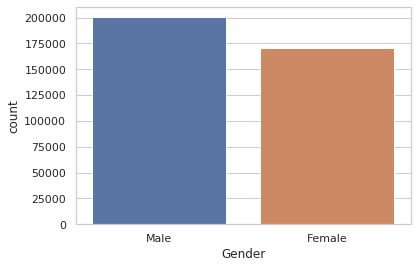

In [23]:
# 우선 남녀 성별 비율에 대해서 확인해보겠습니다

sns.countplot(train['Gender']);

         Response       
Response        0      1
Gender                  
Female     152871  17599
Male       172763  27556


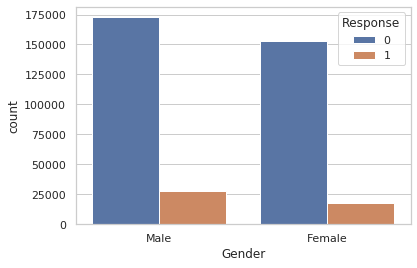

In [24]:
# 자동차보험에 관심을 보인 사람과 그렇지 않은 사람의 남녀 비율을 따로 비교해보겠습니다
df_gender = train.groupby(['Gender', 'Response']).agg({'Response': 'count'}).unstack()
print(df_gender)

sns.countplot(train['Gender'], hue=train['Response'])
plt.show()


성별에 따른 관심도 여부 비율은 비슷한 양상을 가진 것으로 보여집니다



---


>'Age'컬럼에 대해 알아보자

In [25]:
print("'Age'의 최소값은", train['Age'].min())
print("'Age'의 최대값은", train['Age'].max())
print("'Age'의 평균은", train['Age'].mean())
print("'Age'의 중간값은", train['Age'].median())

'Age'의 최소값은 20
'Age'의 최대값은 85
'Age'의 평균은 38.67034351072982
'Age'의 중간값은 36.0


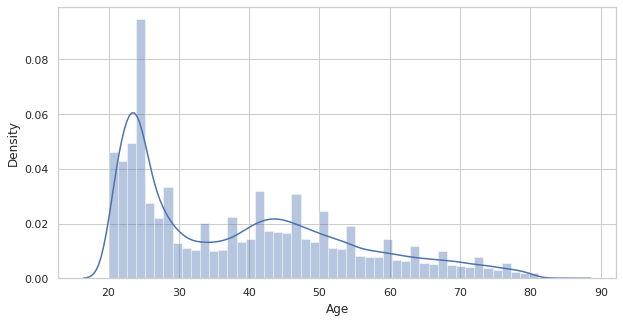

In [26]:
# 연령대 분포를 확인해보겠습니다
plt.figure(figsize=(10,5))
sns.distplot(train['Age']);

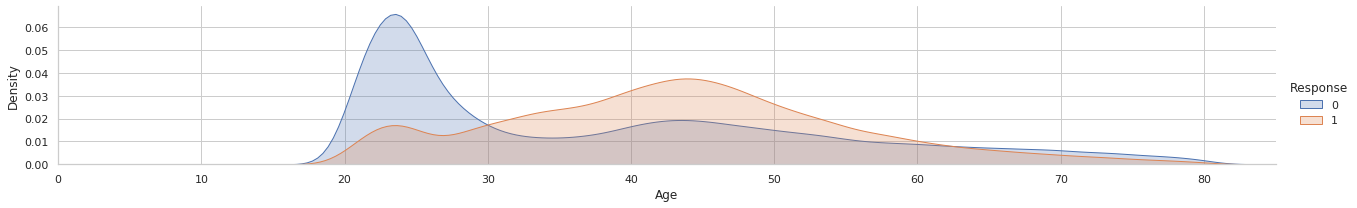

In [27]:
# 자동차보험에 관심을 가진 사람과 그렇지 않은 사람들이 연령대별로 차이가 있는지 확인해보겠습니다
Age = sns.FacetGrid(data=train, hue='Response', aspect=6)
Age.map(sns.kdeplot, 'Age', shade=True)
Age.set(xlim=(0, train['Age'].max()))
Age.add_legend()


In [28]:
# 관심 유무에 따른 연령대 평균
train.groupby('Response').Age.mean()

Response
0   38.0325
1   43.2702
Name: Age, dtype: float64

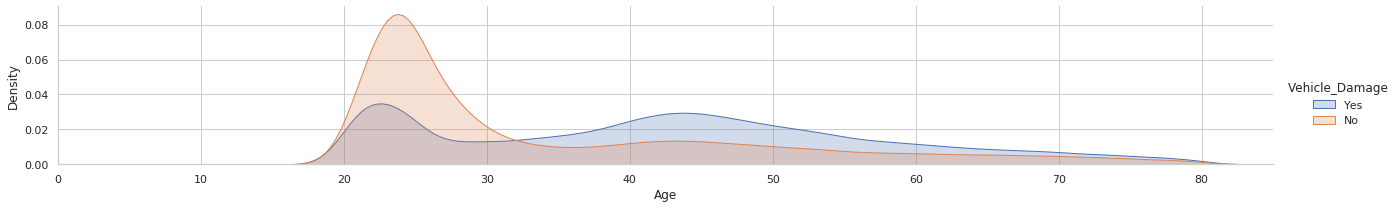

In [29]:
# 연령대 별로 vehicle damage가 있는지 여부를 확인해보겠습니다
Age = sns.FacetGrid(data=train, hue='Vehicle_Damage', aspect=6)
Age.map(sns.kdeplot, 'Age', shade=True)
Age.set(xlim=(0, train['Age'].max()))
Age.add_legend()

*확인해보니 20 - 30대 연령층은 자동차보험에 관심을 보이지 않은 사람의 비율이 상대적으로 높고, 반대로 40 - 50대 연령층은 자동차보험에 관심을 보이는 사람의 비율이 더 높은 것을 확인할 수 있었습니다. 그리고 그 양상은 vehicle damage가 있냐 없냐와 비슷한 양상을 보이고 있었습니다. 그래서 연령과 vehicle damage가 타겟값과 상관관계가 있을거라고 예상해보고 나중에 확인해보겠습니다*



---


>'Annual_Premium' 컬럼


In [30]:
# 자동차보험에 관심을 가진 사람과 그렇지 않은 사람의 Annual Premium 평균에 차이가 있는지 확인해보겠습니다
train.groupby('Response').Annual_Premium.mean()

Response
0   29,162.7175
1   29,999.6835
Name: Annual_Premium, dtype: float64

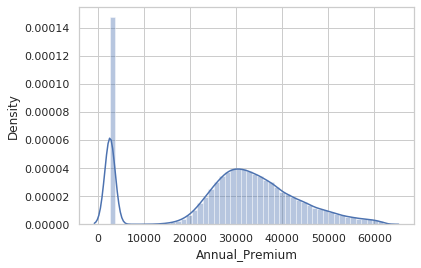

In [31]:
# 전체 리스트의 annual premium의 분포에 대해서 확인해보겠습니다
sns.distplot(train['Annual_Premium']);



---


> 'Vehicle_Damage' 컬럼




               Response       
Response              0      1
Vehicle_Damage                
No               183261    967
Yes              142373  44188


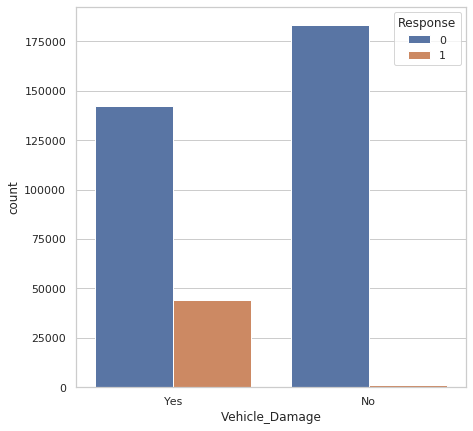

In [32]:
# vehicle damage의 유무에 따른 타겟값을 확인해보겠습니다
df_damage = train.groupby(['Vehicle_Damage', 'Response']).agg({'Response': 'count'}).unstack()
print(df_damage)

plt.figure(figsize=(7,7))
sns.countplot(train['Vehicle_Damage'], hue=train['Response'])
plt.show()



---



> 'Vehicle_Age' 컬럼




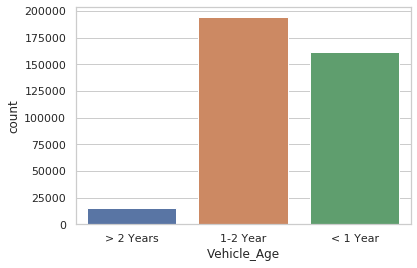

In [33]:
sns.countplot(train['Vehicle_Age']);



---


> 'Region_Code' 컬럼




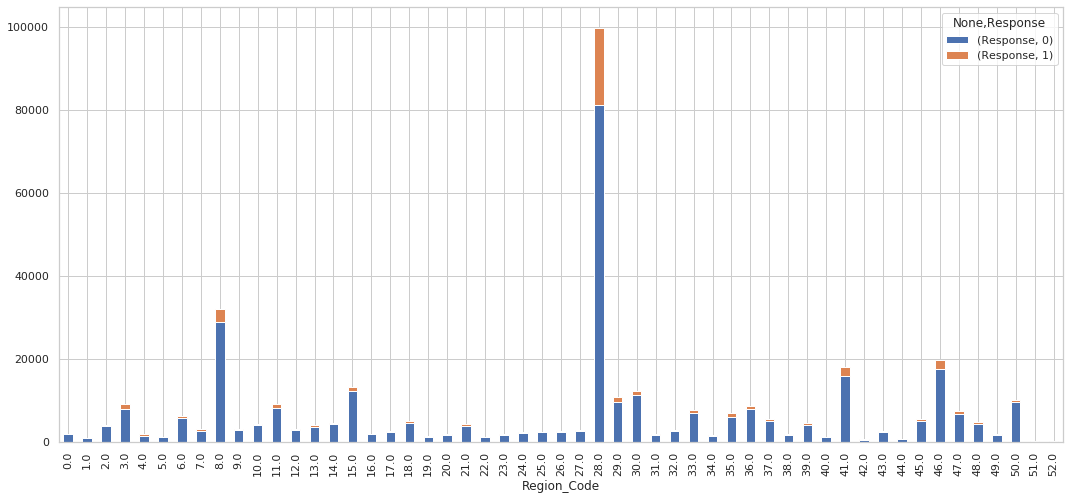

In [34]:
plt.rcParams['figure.figsize'] = 18, 8
df_rc = train.groupby(['Region_Code', 'Response']).agg({'Response': 'count'}).unstack()
df_rc.plot(kind = 'bar', stacked = True)
plt.show()



---


> 'Previously_Insured' 컬럼



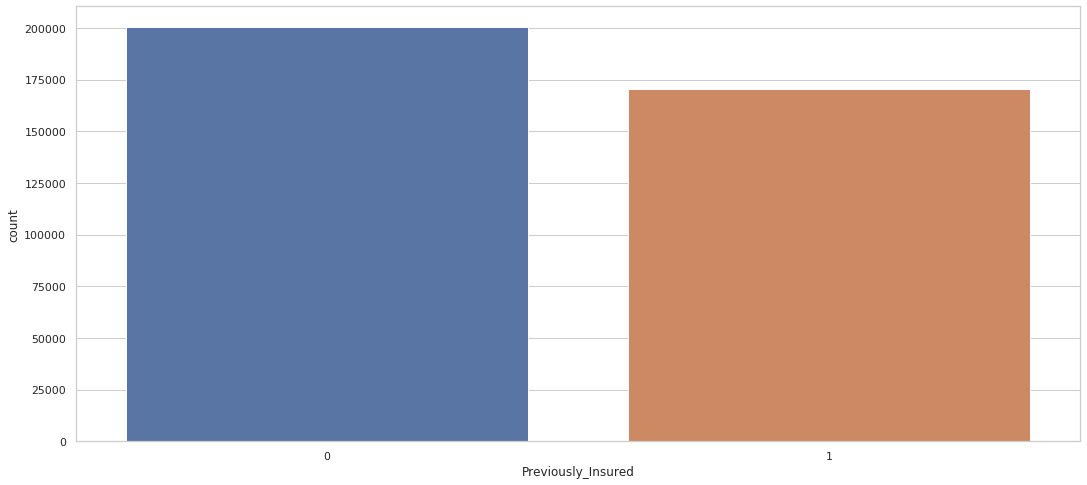

In [35]:
sns.countplot(train['Previously_Insured']);

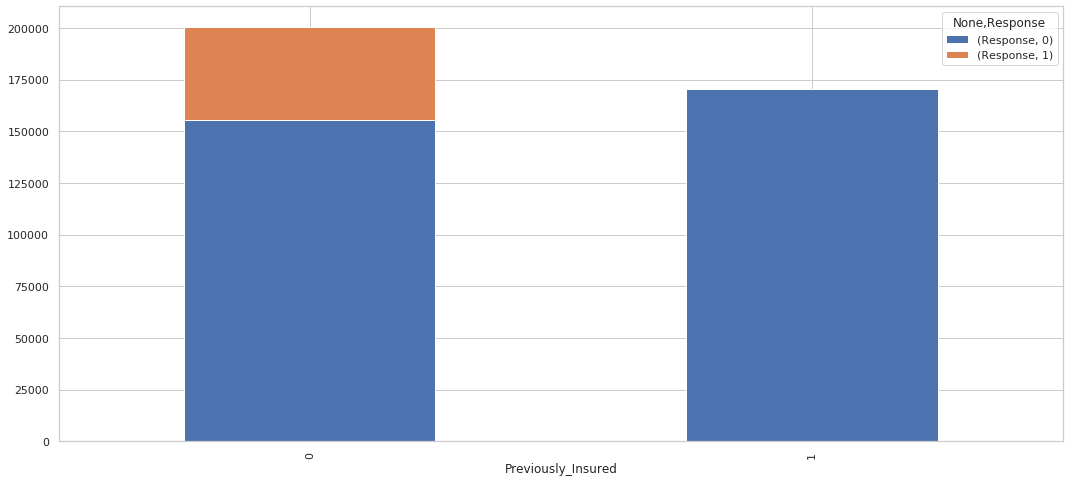

In [36]:
df_pi = train.groupby(['Previously_Insured', 'Response']).agg({'Response': "count"}).unstack()
df_pi.plot(kind = 'bar', stacked = True)
plt.show()



---



> 'Vintage'컬럼



In [37]:
print("'Vintage'의 최소값은", train['Vintage'].min())
print("'Vintage'의 최대값은", train['Vintage'].max())

'Vintage'의 최소값은 10
'Vintage'의 최대값은 299


In [38]:
# 타겟 클래스에 해당하는 Vintage값 평균을 구해보겠습니다
train.groupby('Response').Vintage.mean()

Response
0   154.3963
1   153.9790
Name: Vintage, dtype: float64



---



> 전처리

In [39]:
def preprocessing(df):

    # id 변수를 제거합니다.
    df = df.drop('id', axis = 1)

    # 숫자형이 아닌 컬럼들을 int형으로 전환
    gender = {'Female':0, 'Male':1}
    vehicle_age = {'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}
    damage = {'No':0, 'Yes':1}

    df['Gender'] = df['Gender'].map(gender)
    df['Vehicle_Age'] = df['Vehicle_Age'].map(vehicle_age)
    df['Vehicle_Damage'] = df['Vehicle_Damage'].map(damage)

    return df

train = preprocessing(train)
test = preprocessing(test)

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370789 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                370789 non-null  int64  
 1   Age                   370789 non-null  int64  
 2   Driving_License       370789 non-null  int64  
 3   Region_Code           370789 non-null  float64
 4   Previously_Insured    370789 non-null  int64  
 5   Vehicle_Age           370789 non-null  int64  
 6   Vehicle_Damage        370789 non-null  int64  
 7   Annual_Premium        370789 non-null  float64
 8   Policy_Sales_Channel  370789 non-null  float64
 9   Vintage               370789 non-null  int64  
 10  Response              370789 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 43.9 MB


In [41]:
train['Region_Code'] = train['Region_Code'].astype(int)
train['Annual_Premium'] = train['Annual_Premium'].astype(int)
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype(int)



---



> 상관관계 확인

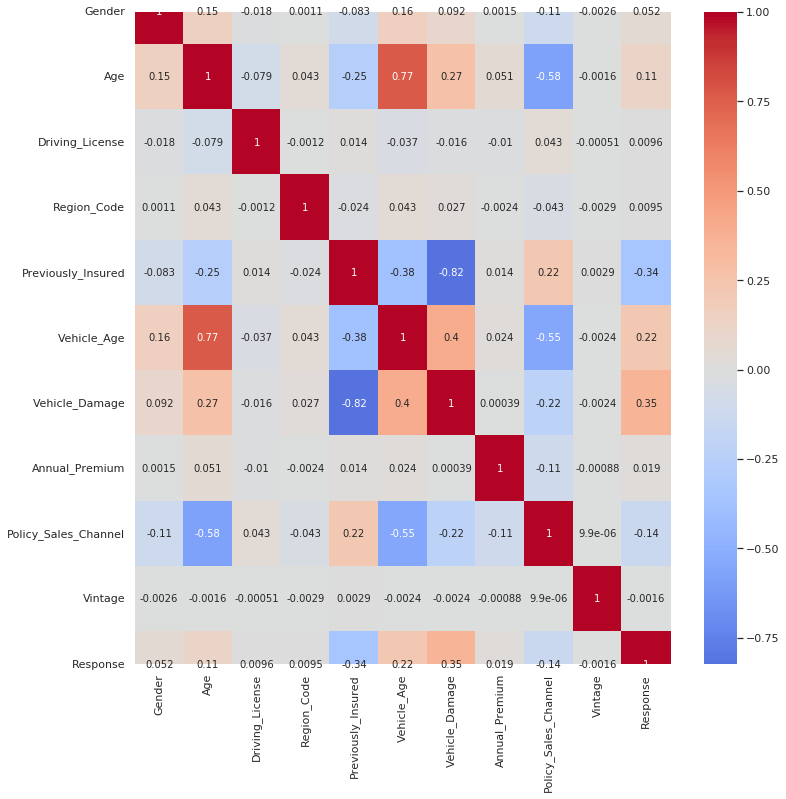

In [42]:
# 상관관계를 히트맵으로 그려 확인해보겠습니다
corr = train.corr(method='pearson')
fig = plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', center = 0);

In [43]:
for col in train.columns:
    if col == 'Response':
        continue
    print(col, train[col].corr(train['Response']))

Gender 0.052305333306900854
Age 0.11093768629522618
Driving_License 0.00963031643055032
Region_Code 0.009473616453076652
Previously_Insured -0.34091304497503344
Vehicle_Age 0.22058664136693557
Vehicle_Damage 0.35409625875771517
Annual_Premium 0.018565719766305458
Policy_Sales_Channel -0.13680463988232175
Vintage -0.0016310494486154604


In [44]:
train = train.drop(columns=['Driving_License', 'Region_Code', 'Vintage'], axis=1)
test = test.drop(columns=['Driving_License', 'Region_Code', 'Vintage'], axis=1)


---
# **3. 기준모델 설정 + 데이터셋 나누기**


##Part 1: 훈련/검증/테스트 데이터로 나누기

In [45]:
# train 데이터를 train/validation set으로 나누면서 stratified로 나누기

train, val = train_test_split(train, train_size=0.70, test_size=0.30, stratify=train['Response'], random_state=2)




---


##Part 2: 타겟과 기준모델 설정



> 클래스를 2개 가지는 분류문제, Binary Classification 문제입니다. 아래 그래프로 클래스의 비율을 확인해보면, imbalanced data라는 것을 확인할 수 있습니다 따라서, 타겟 변수의 최다비율을 기준모델로 설정하겠습니다. 기준모델에는 편중된 범주비율을 가지고 있어서, 클래스가 0에 대한 정확도가 87%인 기준모델을 설정하고 더 좋은 성능을 가지는 모델을 만들어보겠습니다.


0    227944
1     31608
Name: Response, dtype: int64


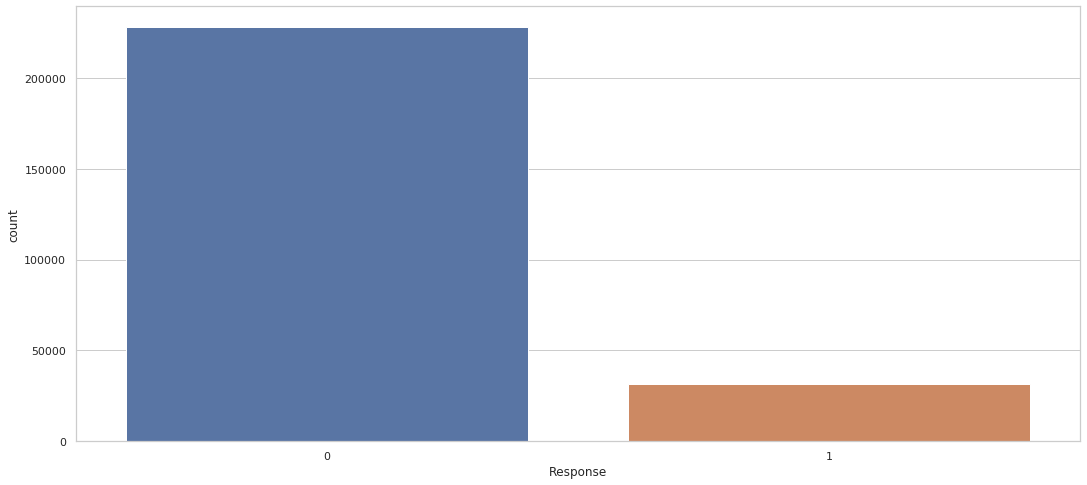

In [46]:
# target은 'Response'
# Response, 0=> not interested / 1=> interested
target = 'Response'

print(train[target].value_counts())
sns.countplot(x=train[target]);

In [47]:
X_train = train.drop(target, axis=1)
X_val = val.drop(target, axis=1)

y_train = train[target]
y_val = val[target]


print("train shape: ", train.shape)
print("val shape: ", val.shape)
print("test shape: ", test.shape)

train shape:  (259552, 8)
val shape:  (111237, 8)
test shape:  (127037, 7)


In [48]:
X_test = test
y_test = sample_submit['Response']

In [49]:
# 클래스 비율이 어떤지 확인합니다. 
y_train = train[target]
y_train.value_counts(normalize=True)

0   0.8782
1   0.1218
Name: Response, dtype: float64

In [50]:
# imbalanced된 비율을 가지고 있음을 확인할 수 있음
# 범주 0으로 모든 예측을 수행해보겟습니다
major = y_train.mode()[0]

# 기준모델로 정확도 측정
from sklearn.metrics import accuracy_score

y_pred = [major] * len(y_train)
y_pred_val = [major] * len(y_val)

print('훈련 정확도: ', accuracy_score(y_train, y_pred))
print('검증 정확도: ', accuracy_score(y_val, y_pred_val))

훈련 정확도:  0.8782209345333498
검증 정확도:  0.8782149824249126



---
# **4. 모델링 (Modeling)**




---
## **4-1. Logistic Regression**



In [51]:
# Logistic 모델을 만들어줌
model_lr = LogisticRegression(random_state=2)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_val)

print('훈련 정확도: ', model_lr.score(X_train, y_train))
print('검증 정확도: ', model_lr.score(X_val, y_val))
print('검증 f1_score: ', f1_score(y_val, y_pred_lr))

print(classification_report(y_val, y_pred_lr))

훈련 정확도:  0.8724147762298113
검증 정확도:  0.8731447270242815
검증 f1_score:  0.10616329891683031
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     97690
           1       0.37      0.06      0.11     13547

    accuracy                           0.87    111237
   macro avg       0.63      0.52      0.52    111237
weighted avg       0.82      0.87      0.83    111237



In [52]:
# 타겟의 클래스가 너무 치우쳐져 성능이 안나오는것 같아서 class_weight=balanced로 설정해서 다시 

model_lr_balanced = LogisticRegression(random_state=2, class_weight='balanced')
model_lr_balanced.fit(X_train, y_train)

y_pred_lr = model_lr_balanced.predict(X_val)

print('훈련 정확도: ', model_lr_balanced.score(X_train, y_train))
print('검증 정확도: ', model_lr_balanced.score(X_val, y_val))
print('검증 f1_score: ', f1_score(y_val, y_pred_lr))

print(classification_report(y_val, y_pred_lr))

훈련 정확도:  0.6257936752558254
검증 정확도:  0.6246572633206577
검증 f1_score:  0.2528542285530224
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     97690
           1       0.17      0.52      0.25     13547

    accuracy                           0.62    111237
   macro avg       0.54      0.58      0.50    111237
weighted avg       0.82      0.62      0.69    111237



In [53]:
coefficients = pd.Series(model_lr_balanced.coef_[0], X_train.columns)
coefficients

Gender                  0.0003
Age                     0.0153
Previously_Insured     -0.0012
Vehicle_Age             0.0009
Vehicle_Damage          0.0014
Annual_Premium         -0.0000
Policy_Sales_Channel   -0.0056
dtype: float64

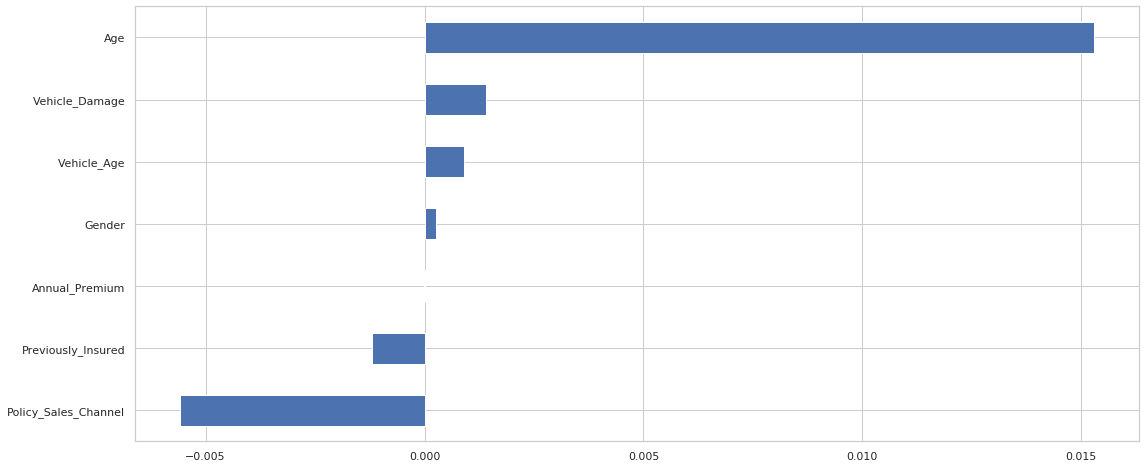

In [54]:
coefficients.sort_values().plot.barh();

***현재 자동차보험 가입을 하지 않은 사람일수록, 나이가 어릴수록, 차에 데미지가 있고 연식이 오래 되었을수록 자동차보험에 더 관심을 가짐을 계수들의 수치로 확인할 수 있다.***



---
## **4-2. Random Forest Classifier**

In [55]:
# random forest를
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(n_estimators=400,
                           n_jobs=-1,
                           max_depth=18,
                           class_weight='balanced',
                           random_state=2)
)

model_rf.fit(X_train, y_train)
print('검증 정확도', model_rf.score(X_val, y_val))

검증 정확도 0.7434936217265837


In [56]:
# random forest모델의 하이퍼파라미터 튜닝을 해보겠습니다
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe_rf = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2, n_jobs=-1,class_weight='balanced')
)

param_dist = {
    'randomforestclassifier__n_estimators': randint(1,100),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1),
    'randomforestclassifier__min_samples_split': [1, 3, 5, 10],
    'randomforestclassifier__min_samples_leaf': [None, 5, 10, 20, 30],  
    'simpleimputer__strategy': ['mean', 'median'], 
}

# fitting 3 folds for each of 30, totalling 90 fits
clf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_dist, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('targetencoder',
                                              TargetEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            min_samples_leaf=1,
                                                            return_df=True,
                                                            smoothing=1.0,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
    

In [57]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.36063801010878216, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 45, 'simpleimputer__strategy': 'mean'}
MAE:  -0.43846532659036425


In [58]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,25,17,26,9,6,10,12,21,27,7,19,0,13,14,2,22,4,20,1,11,28,15,16,8,18,5,23,24,3,29
mean_fit_time,11.9226,25.4224,26.1058,5.5370,2.6726,17.1907,7.3359,2.2752,8.5910,17.0807,24.9559,25.4674,18.3348,2.2645,21.8570,1.7400,14.1423,25.1516,24.1994,24.6620,1.0253,0.7826,0.6987,1.4005,0.8304,0.6759,0.7670,0.9252,0.8500,0.8808
std_fit_time,0.2733,0.1720,0.0830,0.2882,0.2135,0.3021,0.2960,0.0620,2.4852,0.0782,0.2134,0.2132,0.3768,0.0327,2.5047,0.1570,0.4104,2.5391,0.5218,0.2405,0.0970,0.0355,0.1357,0.1782,0.0263,0.0590,0.0958,0.1227,0.0829,0.1012
mean_score_time,0.9657,1.7539,1.0576,0.7429,0.4102,1.7725,0.6997,0.3943,0.8736,0.7170,1.9132,0.8018,1.1691,0.5150,1.2433,0.4371,1.2301,1.8424,1.0122,1.5005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
std_score_time,0.0460,0.1317,0.1434,0.0600,0.0360,0.1516,0.0167,0.0705,0.3745,0.0469,0.0985,0.0927,0.0824,0.0126,0.1553,0.0274,0.1098,0.1350,0.1368,0.0954,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
param_randomforestclassifier__max_depth,20,20,None,None,15,None,None,15,20,10,None,10,10,10,10,5,10,None,5,None,None,5,15,10,15,20,5,20,10,20
param_randomforestclassifier__max_features,0.3606,0.5059,0.9079,0.0471,0.2385,0.0427,0.4737,0.4709,0.2211,0.8015,0.4987,0.7380,0.6138,0.2756,0.4496,0.2101,0.1860,0.6175,0.7490,0.9673,0.7090,0.4370,0.1782,0.8740,0.1435,0.2987,0.6750,0.4836,0.3390,0.6840
param_randomforestclassifier__min_samples_leaf,5,5,20,10,5,5,30,30,30,10,5,20,10,30,10,5,5,5,10,5,5,20,None,10,10,None,20,None,None,None
param_randomforestclassifier__min_samples_split,3,5,3,10,3,5,3,10,3,10,10,10,3,3,5,3,3,5,3,10,1,1,1,1,1,5,1,10,10,3
param_randomforestclassifier__n_estimators,45,77,50,24,12,75,20,5,51,49,73,67,67,5,86,15,81,69,93,44,20,41,36,14,52,82,76,58,42,12
param_simpleimputer__strategy,mean,median,median,mean,median,mean,median,mean,mean,mean,mean,mean,median,median,mean,mean,median,mean,median,median,median,mean,mean,median,mean,mean,mean,median,median,median


In [59]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러오겠습니다
pipe_rf_best = clf.best_estimator_

In [60]:
y_pred_val = pipe_rf_best.predict(X_val)
mae = mean_absolute_error(y_val, y_pred_val)
print(mae)

0.2645792317304494


In [61]:
y_pred_train = pipe_rf_best.predict(X_train)
y_pred_val= pipe_rf_best.predict(X_val)

print('훈련 정확도: ', pipe_rf_best.score(X_train, y_train))
print('검증 정확도: ', pipe_rf_best.score(X_val, y_val))
print('훈련 f1_score: ', f1_score(y_train, y_pred_train))
print('검증 f1_score: ', f1_score(y_val, y_pred_val))

print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.7579290469732463
검증 정확도:  0.7354207682695506
훈련 f1_score:  0.48532905191762643
검증 f1_score:  0.4400175048043077
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     97690
           1       0.30      0.85      0.44     13547

    accuracy                           0.74    111237
   macro avg       0.63      0.79      0.63    111237
weighted avg       0.89      0.74      0.78    111237



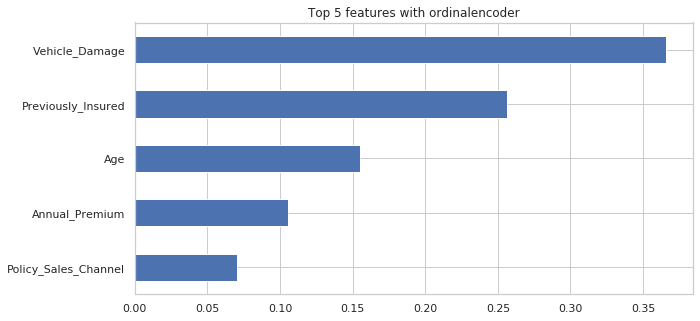

In [62]:
# 모델의 특성 중요도를 살펴보겠습니다
rf = pipe_rf_best.named_steps['randomforestclassifier']
importances_rf = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(10,5))
plt.title('Top 5 features with ordinalencoder')
importances_rf.sort_values()[-5:].plot.barh();

[[70243 27447]
 [ 1984 11563]]


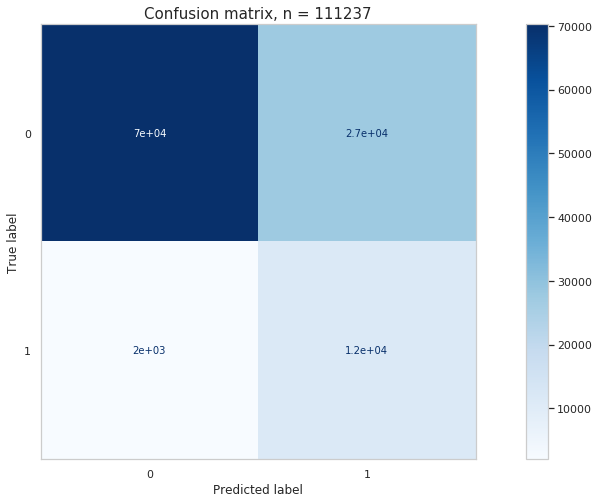

In [63]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf_best, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);

cm=pcm.confusion_matrix
print(cm)

ax.grid(False)
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()




---
## **4-3. XGBoost Classifier**


In [64]:
y_train.value_counts(normalize=True)

0   0.8782
1   0.1218
Name: Response, dtype: float64

In [65]:
ratio = 0.12/0.88

In [66]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

# XGBoost 분류기를 학습시킵니다. 클래스 비율을 맞추기 위해 scale_pos_weight= # 0(not interested) / # 1 (interested)
XGB_model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, max_depth=7, random_state=2, scale_pos_weight=ratio)
XGB_model.fit(X_train_encoded, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.837722	validation_1-auc:0.839731
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.838407	validation_1-auc:0.84041
[2]	validation_0-auc:0.841332	validation_1-auc:0.843109
[3]	validation_0-auc:0.840753	validation_1-auc:0.842756
[4]	validation_0-auc:0.842701	validation_1-auc:0.844394
[5]	validation_0-auc:0.843155	validation_1-auc:0.84484
[6]	validation_0-auc:0.848692	validation_1-auc:0.850288
[7]	validation_0-auc:0.84884	validation_1-auc:0.850266
[8]	validation_0-auc:0.849352	validation_1-auc:0.850572
[9]	validation_0-auc:0.849589	validation_1-auc:0.850711
[10]	validation_0-auc:0.849917	validation_1-auc:0.85111
[11]	validation_0-auc:0.850015	validation_1-auc:0.851207
[12]	validation_0-auc:0.850386	validation_1-auc:0.851398
[13]	validation_0-auc:0.850515	validation_1-auc:0.851518
[14]	validation_0-auc:0.850886	validation_1-auc:0.851783
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.13636363636363635,
              seed=None, silent=None, subsample=1, verbosity=0)

In [67]:
y_pred_proba = XGB_model.predict_proba(X_val_encoded)[:,1]
roc_auc_score(y_val,y_pred_proba)

0.8572134835403511

In [68]:
y_pred_train = XGB_model.predict(X_train)
y_pred_val= XGB_model.predict(X_val)

print('훈련 정확도: ', XGB_model.score(X_train, y_train))
print('검증 정확도: ', XGB_model.score(X_val, y_val))

print(classification_report(y_val, y_pred_val))

훈련 정확도:  0.8782209345333498
검증 정확도:  0.8782149824249126
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     97690
           1       0.00      0.00      0.00     13547

    accuracy                           0.88    111237
   macro avg       0.44      0.50      0.47    111237
weighted avg       0.77      0.88      0.82    111237




---
# **5. 모델 해석 및 시각화**



In [69]:
pipe_rf_best.named_steps

{'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=20,
                        max_features=0.36063801010878216, max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=5,
                        min_samples_split=3, min_weight_fraction_leaf=0.0,
                        n_estimators=45, n_jobs=-1, oob_score=False,
                        random_state=2, verbose=0, warm_start=False),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0),
 'targetencoder': TargetEncoder(cols=[], drop_invariant=False, handle_missing='value',
               handle_unknown='value', min_samples_leaf=1, return_df=True,
               smoothing=1.0, verbose=0)}

In [70]:
permuter = PermutationImportance(
    pipe_rf_best.named_steps['randomforestclassifier'],
    scoring='accuracy', 
    n_iter=5,
    random_state=2
)

In [71]:
X_val_transformed = pipe_rf_best.named_steps['targetencoder'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [72]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Previously_Insured     -0.0577
Vehicle_Damage         -0.0529
Policy_Sales_Channel   -0.0158
Annual_Premium         -0.0009
Gender                  0.0013
Age                     0.0093
Vehicle_Age             0.0307
dtype: float64

In [73]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0307 ± 0.0006,Vehicle_Age
0.0093 ± 0.0008,Age
0.0013 ± 0.0006,Gender
-0.0009 ± 0.0009,Annual_Premium
-0.0158 ± 0.0011,Policy_Sales_Channel
-0.0529 ± 0.0017,Vehicle_Damage
-0.0577 ± 0.0012,Previously_Insured
